# Detecting pneumonia using chest x-rays

### To Do List

#### Research:
* CNNs
    * How do they work?
    * Idea of transfer learning
* Unique CNN implementations: AlexNet, CapsNet, GNN
    * What is unique about each of these implementations?
    
#### Implementation:
* Basic CNNs (PyTorch, tensorflow, keras)
* Transfer learning example
* Unique CNN implementations

#### Blog:
* Choosing a service (Medium, ...)

## Research

#### Convolutional Neural Networks (CNNs)

CNNs are used for classifaction and computer vision. They are made up of three types of layers: convolutional, pooling, and fully-connected (FC). The first layer is a convolutional layer, and the last layer is the only fully-connected layer. The layers in between may be a mix of convolutional and pooling layers [1]. 

##### Convolutional Layers [1]
Convolutiuonal layers have an input, a filter (AKA kernel or feature detector), and a feature map. The feature detector is typically a 2D array of weights, which is applied to a subsection of the input. The dot product between this subsection and the kernel is then calculated. The filter then shifts by a stride, and performs the dot product operation once more, repeating this process until it has covered the entire input. The resulting array of outputs is called the feature map.

Some hyperparameters that can be adjusted in the convolutional layer are number of filters, stride, and zero padding. Number of filters affects the depth of the feature map (e.g. three filters results in a depth three feature map). Stride is the number of pixels the kernel moves after each dot product calculation. Zero padding refers to the amount of padding added to an input (eg. an image) to ensure that the filter fits the image.

After each convolution, the CNN applies a ReLU to introduce nonlinearities into the network, ensuring that the model is a universal approximator.

##### Pooling Layers [1]
Similar to a convolutional layer, except the filter does not use weights. Instead it implements a specific type of pooling: max pooling or average pooling. Max pooling is when the filter selects the pixel of maximum value to send to the output array. Average pooling is when the filter calculates the average value in the receptive field (the values that the filter can see).

More information is lost in pooling layers, but they "reduce complexity, improve efficiency, and limit risk of overfitting".

##### Fully-Connected Layer [1]
Usually uses a softmax activation function to make the final classification prediction.

## Implementation

In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

#### EDA (Exploratory Data Analysis) [2]

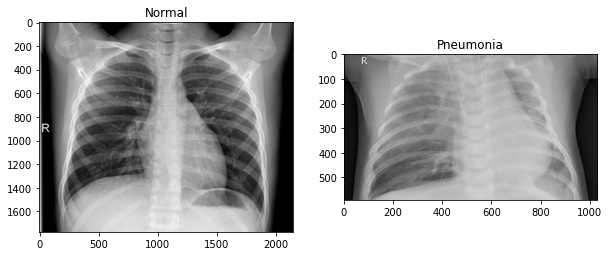

In [27]:
train_normal = './chest_xray/train/NORMAL/'
train_pneumonia = './chest_xray/train/PNEUMONIA/'

random_norm = np.random.randint(0, len(os.listdir(train_normal)))
normal_pic = os.listdir(train_normal)[random_norm] 

random_pneu = np.random.randint(0, len(os.listdir(train_pneumonia)))
pneumonia_pic = os.listdir(train_pneumonia)[random_pneu]

normal_load = Image.open(train_normal+normal_pic)
pneumonia_load = Image.open(train_pneumonia+pneumonia_pic)

fig = plt.figure(figsize=(10,6))
a1 = fig.add_subplot(1,2,1)
plt.imshow(normal_load, cmap='gray')
a1.set_title('Normal')

a2 = fig.add_subplot(1, 2, 2)
plt.imshow(pneumonia_load, cmap='gray')
a2.set_title('Pneumonia')

plt.show()

## References

[1] https://www.ibm.com/cloud/learn/convolutional-neural-networks

[2] https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia